# Uplift Modeling: Individual Treatment Effects

This notebook implements uplift modeling to predict **individual treatment effects (ITE)** for each user.

**Key difference from causal inference:**
- Causal inference estimates **average** treatment effects (ATE)
- Uplift modeling estimates **individual** treatment effects (ITE) to enable personalized targeting

**Methods implemented:**
1. Two-model approach (separate models for treated and control)
2. Uplift Random Forest (using CausalML)
3. Evaluation via Qini curves and uplift curves


In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier

# Add src to path
PROJECT_ROOT = "/Users/mbgirish/Causal Impact & Uplift Modeling"
sys.path.insert(0, os.path.join(PROJECT_ROOT, "src"))

from preprocessing import (
    ColumnConfig,
    load_marketing_data,
    stratified_train_test_split,
)
from causal_models import fit_propensity_score_model
from uplift_models import (
    train_two_model_uplift,
    predict_two_model_uplift,
)
from evaluation import uplift_and_qini

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (10, 6)

# Load data (reuse from causal inference notebook)
DATA_PATH = os.path.join(PROJECT_ROOT, "data")
DATA_FILE = os.path.join(DATA_PATH, "marketing_campaign.csv")

column_config = ColumnConfig(
    user_id_col="user_id",
    treatment_col="treatment",
    outcome_col="purchase",
)

# Load or generate synthetic data
if os.path.exists(DATA_FILE):
    _df, column_config = load_marketing_data(DATA_FILE, column_config)
else:
    print("⚠ Generating synthetic data...")
    np.random.seed(42)
    n = 10000
    _df = pd.DataFrame({
        "user_id": [f"user_{i}" for i in range(n)],
        "age": np.random.normal(35, 12, n).clip(18, 80),
        "gender": np.random.choice(["M", "F", "Other"], n, p=[0.48, 0.50, 0.02]),
        "country": np.random.choice(["US", "UK", "CA", "DE", "FR"], n, p=[0.5, 0.2, 0.1, 0.1, 0.1]),
        "sessions_last_30d": np.random.poisson(8, n),
        "orders_last_6m": np.random.poisson(2, n),
        "total_spent_last_6m": np.random.gamma(2, 50, n),
        "recency_days": np.random.exponential(30, n).clip(0, 180),
        "email_subscribed": np.random.choice([0, 1], n, p=[0.3, 0.7]),
        "signup_channel": np.random.choice(["organic", "paid", "referral"], n, p=[0.6, 0.3, 0.1]),
    })
    ps_logit = (
        -2.0
        + 0.05 * (_df["age"] - 35) / 12
        + 0.3 * (_df["sessions_last_30d"] - 8) / 3
        + 0.2 * (_df["orders_last_6m"] - 2)
        - 0.01 * _df["recency_days"] / 30
        + 0.5 * (_df["country"] == "US").astype(int)
    )
    ps = 1 / (1 + np.exp(-ps_logit))
    _df["treatment"] = np.random.binomial(1, ps, n)
    base_prob = (
        0.1
        + 0.02 * (_df["age"] - 35) / 12
        + 0.05 * (_df["sessions_last_30d"] - 8) / 3
        + 0.1 * (_df["orders_last_6m"] - 2)
        - 0.01 * _df["recency_days"] / 30
    )
    treatment_effect = (
        0.15
        + 0.1 * (_df["sessions_last_30d"] > 10).astype(int)
        - 0.05 * (_df["recency_days"] > 60).astype(int)
    )
    purchase_prob = np.clip(base_prob + _df["treatment"] * treatment_effect, 0, 1)
    _df["purchase"] = np.random.binomial(1, purchase_prob, n)
    column_config.numeric_features = ["age", "sessions_last_30d", "orders_last_6m", "total_spent_last_6m", "recency_days"]
    column_config.categorical_features = ["gender", "country", "email_subscribed", "signup_channel"]

df_train, df_test = stratified_train_test_split(_df, column_config, test_size=0.3, random_state=42)
print(f"Train: {df_train.shape}, Test: {df_test.shape}")


Train: (44800, 10), Test: (19200, 10)


## 1. Two-Model Uplift Approach

Train separate models:
- **Model 1**: Predict P(Y=1 | T=1, X) using treated users
- **Model 2**: Predict P(Y=1 | T=0, X) using control users
- **Uplift**: ITE = P(Y=1 | T=1, X) - P(Y=1 | T=0, X)


✓ Trained two-model uplift using 7 features
Features: ['recency_days', 'total_spent_last_6m', 'used_discount_before', 'used_bogo_before', 'is_referral_user', 'zip_code', 'channel']

Uplift statistics (test set):
count    19200.000000
mean         0.060402
std          0.061376
min         -0.776456
25%          0.034482
50%          0.057542
75%          0.086461
max          0.603253
Name: uplift, dtype: float64


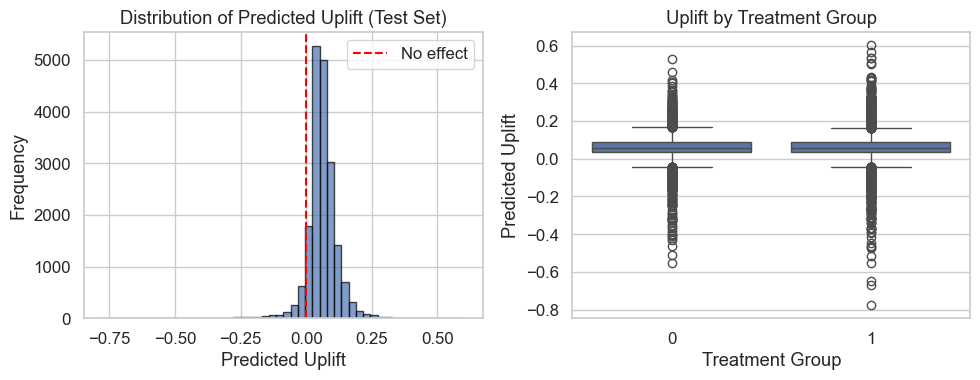

In [2]:
# Train two-model uplift
two_model_result, feature_cols = train_two_model_uplift(
    df_train,
    column_config,
    base_model_cls=GradientBoostingClassifier,
    model_kwargs={"n_estimators": 100, "max_depth": 5, "random_state": 42},
)

print(f"✓ Trained two-model uplift using {len(feature_cols)} features")
print(f"Features: {feature_cols}")

# Predict on train and test
df_train_pred = predict_two_model_uplift(df_train, two_model_result, feature_cols)
df_test_pred = predict_two_model_uplift(df_test, two_model_result, feature_cols)

print("\nUplift statistics (test set):")
print(df_test_pred["uplift"].describe())

# Visualize uplift distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df_test_pred["uplift"], bins=50, alpha=0.7, edgecolor="black")
plt.axvline(0, color="red", linestyle="--", label="No effect")
plt.xlabel("Predicted Uplift")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Uplift (Test Set)")
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(data=df_test_pred, x=column_config.treatment_col, y="uplift")
plt.xlabel("Treatment Group")
plt.ylabel("Predicted Uplift")
plt.title("Uplift by Treatment Group")
plt.tight_layout()
plt.show()


## 2. Uplift Random Forest (CausalML)

For comparison, we'll also use a dedicated uplift model from CausalML.


✓ Trained Uplift Random Forest
Uplift RF statistics (test): count    19200.000000
mean        -0.001667
std          0.064530
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
dtype: float64


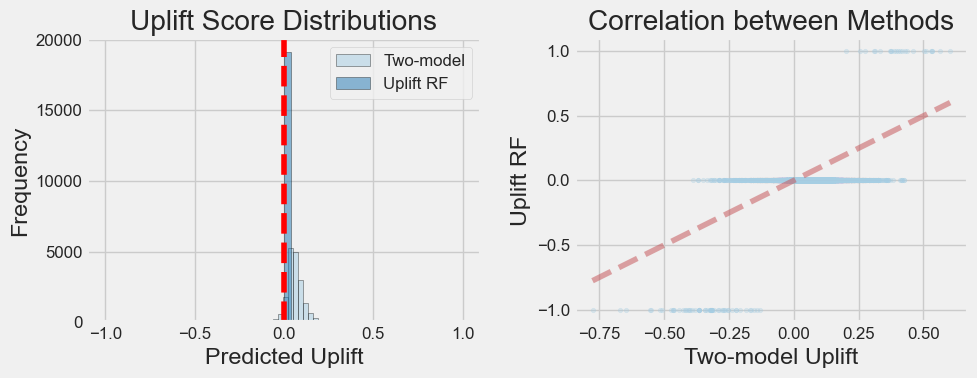

In [3]:
try:
    from causalml.inference.meta import BaseTRegressor
    
    # Prepare data for CausalML
    X_train_clean = df_train[feature_cols].fillna(0)
    T_train = df_train[column_config.treatment_col].values
    Y_train = df_train[column_config.outcome_col].values
    
    X_test_clean = df_test[feature_cols].fillna(0)
    T_test = df_test[column_config.treatment_col].values
    Y_test = df_test[column_config.outcome_col].values
    
    # One-hot encode categoricals manually for CausalML
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.compose import ColumnTransformer
    
    preprocess = ColumnTransformer(
        transformers=[
            ("num", "passthrough", column_config.numeric_features or []),
            ("cat", OneHotEncoder(handle_unknown="ignore"), column_config.categorical_features or []),
        ]
    )
    
    X_train_processed = preprocess.fit_transform(X_train_clean)
    X_test_processed = preprocess.transform(X_test_clean)
    
    # Train Uplift Random Forest
    uplift_rf = BaseTRegressor(learner=GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42))
    uplift_rf.fit(X_train_processed, T_train, Y_train)
    
    # Predict uplift
    uplift_rf_scores = uplift_rf.predict(X_test_processed)
    # Flatten to 1D array if needed (some models return 2D arrays)
    if uplift_rf_scores.ndim > 1:
        uplift_rf_scores = uplift_rf_scores.flatten()
    df_test_pred["uplift_rf"] = uplift_rf_scores
    
    print("✓ Trained Uplift Random Forest")
    print(f"Uplift RF statistics (test): {pd.Series(uplift_rf_scores).describe()}")
    
    # Compare distributions
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(df_test_pred["uplift"], bins=50, alpha=0.5, label="Two-model", edgecolor="black")
    plt.hist(df_test_pred["uplift_rf"], bins=50, alpha=0.5, label="Uplift RF", edgecolor="black")
    plt.axvline(0, color="red", linestyle="--")
    plt.xlabel("Predicted Uplift")
    plt.ylabel("Frequency")
    plt.title("Uplift Score Distributions")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.scatter(df_test_pred["uplift"], df_test_pred["uplift_rf"], alpha=0.3, s=10)
    plt.xlabel("Two-model Uplift")
    plt.ylabel("Uplift RF")
    plt.title("Correlation between Methods")
    plt.plot([df_test_pred["uplift"].min(), df_test_pred["uplift"].max()],
             [df_test_pred["uplift"].min(), df_test_pred["uplift"].max()],
             "r--", alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    use_uplift_rf = True
except ImportError:
    print("⚠ CausalML not installed. Skipping Uplift Random Forest.")
    print("  Install with: pip install causalml")
    use_uplift_rf = False


## 3. Evaluation: Qini and Uplift Curves

Rank users by predicted uplift and measure incremental conversions as we target more users.


Two-Model Uplift Results:
Qini coefficient: 68.1142


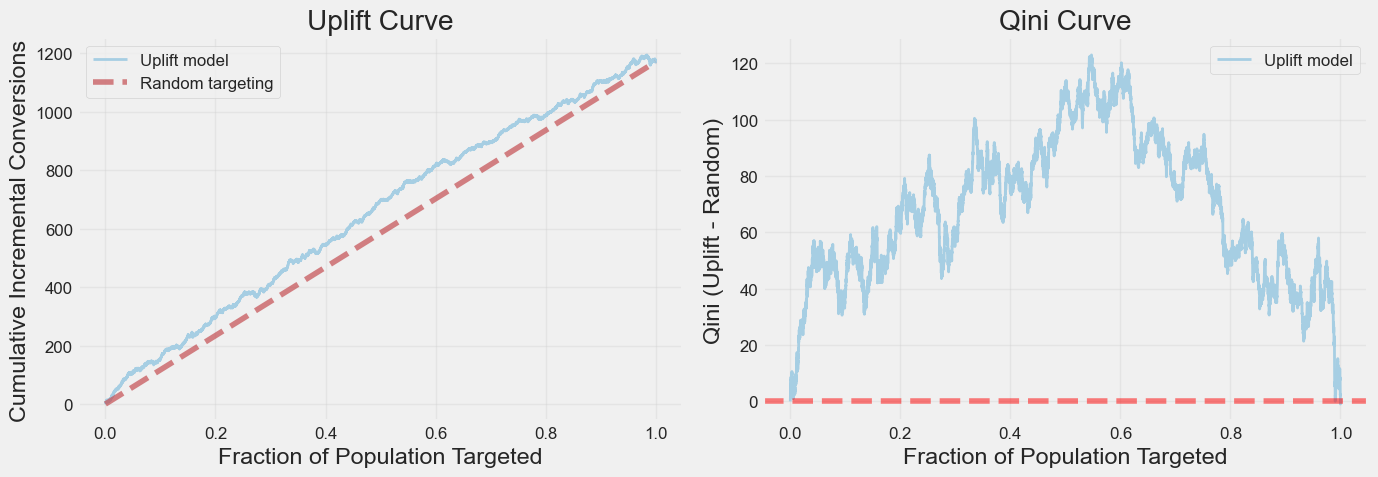


Uplift RF Qini coefficient: 29.2004


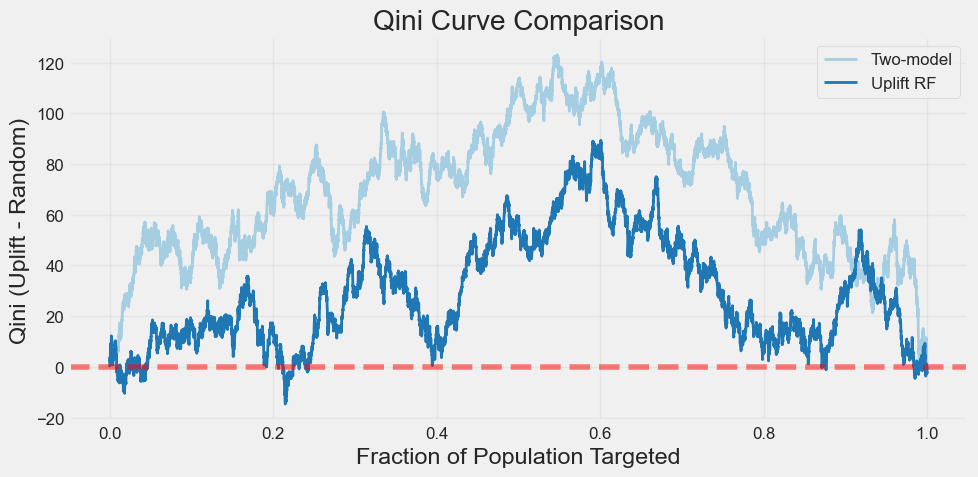

In [4]:
# Evaluate on test set
Y_test = df_test_pred[column_config.outcome_col].values
T_test = df_test_pred[column_config.treatment_col].values

# Two-model evaluation
results_two_model = uplift_and_qini(Y_test, T_test, df_test_pred["uplift"].values)

print("Two-Model Uplift Results:")
print(f"Qini coefficient: {results_two_model['qini_coef']:.4f}")

# Plot uplift and Qini curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Uplift curve
axes[0].plot(results_two_model["frac"], results_two_model["uplift_curve"], label="Uplift model", linewidth=2)
axes[0].plot([0, 1], [0, results_two_model["uplift_curve"][-1]], "r--", label="Random targeting", alpha=0.7)
axes[0].set_xlabel("Fraction of Population Targeted")
axes[0].set_ylabel("Cumulative Incremental Conversions")
axes[0].set_title("Uplift Curve")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Qini curve
axes[1].plot(results_two_model["frac"], results_two_model["qini_curve"], label="Uplift model", linewidth=2)
axes[1].axhline(0, color="red", linestyle="--", alpha=0.5)
axes[1].set_xlabel("Fraction of Population Targeted")
axes[1].set_ylabel("Qini (Uplift - Random)")
axes[1].set_title("Qini Curve")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Compare with Uplift RF if available
if use_uplift_rf:
    results_rf = uplift_and_qini(Y_test, T_test, df_test_pred["uplift_rf"].values)
    print(f"\nUplift RF Qini coefficient: {results_rf['qini_coef']:.4f}")
    
    plt.figure(figsize=(10, 5))
    plt.plot(results_two_model["frac"], results_two_model["qini_curve"], label="Two-model", linewidth=2)
    plt.plot(results_rf["frac"], results_rf["qini_curve"], label="Uplift RF", linewidth=2)
    plt.axhline(0, color="red", linestyle="--", alpha=0.5)
    plt.xlabel("Fraction of Population Targeted")
    plt.ylabel("Qini (Uplift - Random)")
    plt.title("Qini Curve Comparison")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


## 4. Conditional Average Treatment Effects (CATE) by Segment

Group users by characteristics and compute average uplift within each segment.


Conditional Average Treatment Effects by Segment:
      Segment     N     CATE  Mean baseline prob
    All users 19200 0.060402            0.105858
High spending  9599 0.061967            0.128163
 Low spending  9601 0.058837            0.083558
 High recency  9597 0.058985            0.084550
  Low recency  9603 0.061818            0.127152


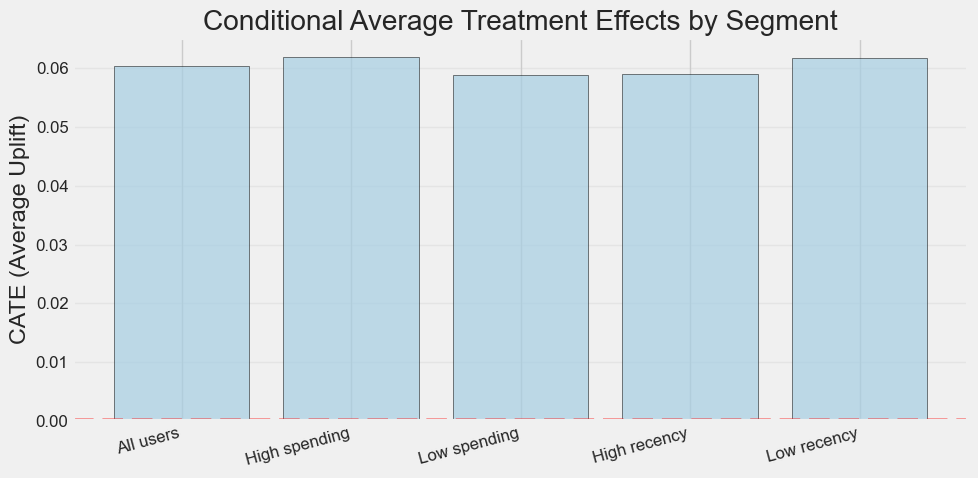

In [5]:
# Segment by key features and compute CATE
# Use actual columns from the dataset
numeric_features = column_config.numeric_features or []

# Check which features are available for segmentation
available_features = [f for f in numeric_features if f in df_test_pred.columns]

if "total_spent_last_6m" in df_test_pred.columns:
    df_test_pred["spending_high"] = (df_test_pred["total_spent_last_6m"] > df_test_pred["total_spent_last_6m"].median()).astype(int)
if "recency_days" in df_test_pred.columns:
    df_test_pred["recency_high"] = (df_test_pred["recency_days"] > df_test_pred["recency_days"].median()).astype(int)

cate_segments = []

# Build segment masks based on available features
segment_masks = [("All users", np.ones(len(df_test_pred), dtype=bool))]

if "total_spent_last_6m" in df_test_pred.columns:
    segment_masks.extend([
        ("High spending", df_test_pred["spending_high"] == 1),
        ("Low spending", df_test_pred["spending_high"] == 0),
    ])
if "recency_days" in df_test_pred.columns:
    segment_masks.extend([
        ("High recency", df_test_pred["recency_high"] == 1),
        ("Low recency", df_test_pred["recency_high"] == 0),
    ])

for segment_name, mask in segment_masks:
    segment_df = df_test_pred[mask]
    if len(segment_df) > 0:
        cate = segment_df["uplift"].mean()
        n = len(segment_df)
        cate_segments.append({
            "Segment": segment_name,
            "N": n,
            "CATE": cate,
            "Mean baseline prob": segment_df["p_control"].mean(),
        })

cate_df = pd.DataFrame(cate_segments)
print("Conditional Average Treatment Effects by Segment:")
print(cate_df.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 5))
bars = plt.bar(cate_df["Segment"], cate_df["CATE"], alpha=0.7, edgecolor="black")
plt.axhline(0, color="red", linestyle="--", alpha=0.5)
plt.ylabel("CATE (Average Uplift)")
plt.title("Conditional Average Treatment Effects by Segment")
plt.xticks(rotation=15, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


## 5. Save Predictions for Business Analysis

Save uplift predictions for the next notebook (business insights and segmentation).


In [6]:
# Save predictions
RESULTS_PATH = os.path.join(PROJECT_ROOT, "results")
os.makedirs(RESULTS_PATH, exist_ok=True)

output_file = os.path.join(RESULTS_PATH, "uplift_predictions.csv")
df_test_pred[[column_config.user_id_col, "uplift", "p_treated", "p_control"]].to_csv(
    output_file, index=False
)
print(f"✓ Saved uplift predictions to {output_file}")

# Also save the two_model_result for reuse
import pickle
model_file = os.path.join(RESULTS_PATH, "two_model_uplift.pkl")
with open(model_file, "wb") as f:
    pickle.dump({"model": two_model_result, "features": feature_cols}, f)
print(f"✓ Saved model to {model_file}")


✓ Saved uplift predictions to /Users/mbgirish/Causal Impact & Uplift Modeling/results/uplift_predictions.csv
✓ Saved model to /Users/mbgirish/Causal Impact & Uplift Modeling/results/two_model_uplift.pkl
